# Gender image categorization using neural networks


## Author: Ángel López Manríquez


### Objectives: 
Given an image with only one face, determine its gender.
### What is done in the Notebook: 
Preprocessing the data and the use of several classifiers algorithms.

In [1]:
# Fundamental datascience libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  # computer vision 2 library
import cvlib as cv  # face feature

# standard python modules
import random
import os
import urllib.request  # fetch images from an url

# keras stuff
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split



from IPython.display import display, HTML, Markdown  # exclusive for jupyter notebook
from tqdm import tqdm  # Very cool progress bar :D
from typing import List, Tuple  # Explicit declaration type for collections, python 3.7+
from collections import Counter  # counts how many instance we have

from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')  # improve plot style

def display_markdown(*args, **kargs):
    '''The main use of is beeing able to display something in a notebook from another function.'''
    display(Markdown(*args, **kargs))

## Data visualization
By loading the dataset, we realize the we only care about the image url and the gender label, everything else is useless. 

In [3]:
fname = 'a943287.csv'  # dataset name
df = pd.read_csv(fname)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


Let's count the number of instances per class.



In [4]:
gender_labels = df.please_select_the_gender_of_the_person_in_the_picture.values
counter = Counter(gender_labels)
display(counter)  # display unique label values

Counter({'male': 47595, 'female': 7367, 'unsure': 9122})

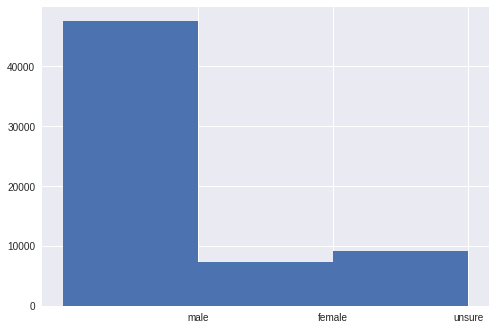

In [5]:
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

We realize there are some images which does not contain faces, tagged as 'unsure', we will drop them.
Also, we have more samples for man than woman, Our approach will be training the model with the same amount of man and woman faces.

In [6]:
display('''Lenght with "unsure" labels''', df.shape)
df = df[df.please_select_the_gender_of_the_person_in_the_picture != 'unsure']  # drop irrelevant rows
display('''Lenght without "unsure" labels''', df.shape)

'Lenght with "unsure" labels'

(64084, 10)

'Lenght without "unsure" labels'

(54962, 10)

In [7]:
df = df[['image_url', 'please_select_the_gender_of_the_person_in_the_picture']]
df.rename(columns={'image_url':'url',
                          'please_select_the_gender_of_the_person_in_the_picture':'gender'}, 
                 inplace=True)

display(df.head())


,url,gender
0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,male
1,https://d1qb2nb5cznatu.cloudfront.net/users/42...,male
2,https://d1qb2nb5cznatu.cloudfront.net/users/44...,male
3,https://d1qb2nb5cznatu.cloudfront.net/users/47...,male
4,https://d1qb2nb5cznatu.cloudfront.net/users/50...,male


In [8]:

X = df['url'].values  # list of urls where will be able to download the image
y = df['gender'].values


### Setting the dataset
Now, let's download the dataset. We will download the images, create directoris img, img/male, img/female and store the images in the corresponding directory.

Some images could not be downloaded (they doesn't exists anymore), some of them could not be opened, we discard them.

In [9]:

def make_dir(folder: str) -> None:
    '''Create the folder even, if it exists no changes or exceptions will be executed. '''
    if not os.path.exists(folder):
        os.mkdir(folder)

def save_img(img_url: str, filepath: str) -> np.array:
    '''Create the file and save it, if we cannot download it an exception will be raised.
    We may return a None object, meaning that we could not open the image (very weird scenario). '''
    try:
        with urllib.request.urlopen(img_url) as url:
            s = url.read()  # read the image in the website if posible.
    except urllib.error.HTTPError as e:
        print(e)
        raise
    with open(filepath, 'wb') as f:
        f.write(s)  # save the image
    return cv2.imread(filepath)  # return the image as np.array


In [10]:
def download_males_females(df, n: int, label_names=['female', 'male']):
    '''Download n images for each gender.'''
    i = 0
    imgs, labels = [], []  # define containers
    for name, group in df.groupby('gender'):  # group them, we attempt to balance the number of instances
        download_count = 0 
        for row_index, row in group.iterrows():
            try:
                fpath = os.path.join('img', row['gender'], f'{i}.jpeg')
                im = save_img(row['url'], fpath)  # exception may occur here
                if im is None:  # The image exists, we store it but we couldn't opened it. Remove it and try the next one
                    if os.path.exists(fpath): os.remove(fpath)
                    print(f'Cannot open {fpath}')
                    continue
                imgs.append(im)
                labels.append(row['gender'])
                download_count += 1
                print(f' {download_count} / {n}', end='  ')
            except urllib.error.HTTPError:
                print(f'Image {i} could not be download or open, trying the next one.')
            i += 1
            if download_count == n: break  # We have reached the number of instances required
    return imgs, labels


In [11]:
def gender_imgs(gender: str, n: int) -> List[np.array]:
    '''Returns an array for the first n images in the directory, gender must be male or female.'''
    subdir = os.path.join('img', gender)
    bnames = list(os.listdir(subdir))
    bnames.sort()  # sort the content, by default listdir doesn't guarantee the result sorted
    bnames = bnames[:n]
    # result = [cv2.imread(os.path.join(subdir, bname), cv2.IMREAD_GRAYSCALE) for bname in bnames]
    result = [cv2.imread(os.path.join(subdir, bname)) for bname in bnames]
    return result

def get_dataset(n: int):
    '''Store the dataset, we suppose the images are already downloaded in each directory. '''
    males = gender_imgs('male', n)
    females = gender_imgs('female', n)
    X = females
    y = [0 for _ in females]
    X += males
    y += [1 for _ in males]
    return X, y

In [12]:

def set_local_dataset(df, n: int) -> Tuple[list, list]:
    '''Returns a tuple of list X, y. Each x in X will be an image as np.array.'''
    make_dir('img')
    make_dir(os.path.join('img', 'male'))
    make_dir(os.path.join('img', 'female'))
    
    male_img_length = len(os.listdir(os.path.join('img', 'male')))
    female_img_length = len(os.listdir(os.path.join('img', 'female')))
    
    if male_img_length >= n and female_img_length >= n:  # we have enough images downloaded
        return get_dataset(n)
    return download_males_females(df, n)



In [13]:
X, y = set_local_dataset(df, 512)  # set a list of images as np.array



 1 / 512   2 / 512   3 / 512   4 / 512  HTTP Error 403: Forbidden
Image 4 could not be download or open, trying the next one.
 5 / 512   6 / 512   7 / 512   8 / 512   9 / 512   10 / 512   11 / 512   12 / 512   13 / 512   14 / 512   15 / 512   16 / 512   17 / 512   18 / 512   19 / 512   20 / 512   21 / 512   22 / 512   23 / 512   24 / 512   25 / 512   26 / 512   27 / 512  Cannot open img/female/28.jpeg
 28 / 512   29 / 512   30 / 512   31 / 512   32 / 512   33 / 512   34 / 512   35 / 512   36 / 512   37 / 512   38 / 512   39 / 512   40 / 512   41 / 512   42 / 512   43 / 512   44 / 512   45 / 512   46 / 512   47 / 512   48 / 512   49 / 512  Cannot open img/female/50.jpeg
 50 / 512   51 / 512   52 / 512   53 / 512   54 / 512   55 / 512   56 / 512   57 / 512   58 / 512   59 / 512   60 / 512   61 / 512   62 / 512   63 / 512   64 / 512   65 / 512   66 / 512   67 / 512   68 / 512   69 / 512   70 / 512   71 / 512   72 / 512   73 / 512   74 / 512   75 / 512   76 / 512   77 / 512   78 / 512   79

 39 / 512   40 / 512   41 / 512   42 / 512   43 / 512   44 / 512   45 / 512   46 / 512   47 / 512   48 / 512   49 / 512   50 / 512   51 / 512   52 / 512   53 / 512   54 / 512   55 / 512   56 / 512   57 / 512   58 / 512   59 / 512   60 / 512   61 / 512   62 / 512   63 / 512   64 / 512   65 / 512   66 / 512   67 / 512   68 / 512   69 / 512   70 / 512   71 / 512   72 / 512   73 / 512   74 / 512   75 / 512   76 / 512   77 / 512   78 / 512   79 / 512   80 / 512   81 / 512   82 / 512   83 / 512   84 / 512   85 / 512   86 / 512   87 / 512   88 / 512   89 / 512   90 / 512   91 / 512   92 / 512   93 / 512   94 / 512   95 / 512   96 / 512   97 / 512   98 / 512   99 / 512   100 / 512   101 / 512   102 / 512   103 / 512   104 / 512   105 / 512   106 / 512   107 / 512   108 / 512   109 / 512   110 / 512   111 / 512   112 / 512   113 / 512   114 / 512   115 / 512   116 / 512   117 / 512   118 / 512   119 / 512   120 / 512   121 / 512   122 / 512   123 / 512   124 / 512   125 / 512   126 / 512   127 

### Preprocess the image
Now, we need to apply feature extraction, we only care for faces rather than all the scenario. We obtain the faces from the image and train the model with them. The process is very straightforward with the cvlib library.



In [20]:


def faces_from_image(image: np.array) -> np.array:
    '''Given an image as np.array, we return a list of faces with a size of (96, 96). 
    If there're no faces, we return an empty list, if we cannot resize the image we return a None object. '''
    faces = []
    face, confidence = cv.detect_face(image)  
    for f in face:  # loop through each face
        (startX, startY) = f[0], f[1]  # get the corners for each image
        (endX, endY) = f[2], f[3]
        # cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)  # draw rectangle over face
        face_crop = np.copy(image[startY:endY, startX:endX])  # crop the detected face region

        # preprocessing for gender detection model
        try:
            face_crop = cv2.resize(face_crop, (96,96))   # Resize every single image for the neural network
        except Exception as e:
            print(e)  # We cannot resize the desire image, return None
            return None
        face_crop = face_crop.astype("float") / 255.0  # normalize the image, as type float
        face_crop = img_to_array(face_crop)  # pass image to array
        # face_crop = np.expand_dims(face_crop, axis=0)
        faces.append(face_crop)
    return np.array(faces)



In [21]:
def plot_img(img):
    plt.imshow(img)
    plt.show()

In [27]:

def preprocess(X: list, y: list):
    '''Extract the images X, y such that we could actually extract a face and could resize it.'''
    x_faces, y_faces = [], []  # to return
    for i, image in enumerate(X):
        faces = faces_from_image(image)  # get the faces list
        if faces is None or faces.shape[0] == 0:  # if we could resize face of the image and there are people in the image
            continue  # No image found
        x_faces.append(faces[0])  # append the first face 
        y_faces.append(y[i])  # append the label
    return np.array(x_faces), np.array(y_faces)  # return filtered X, y



In [28]:
# before 
print(len(X))
print(len(y))

X, y = preprocess(X, y)

# after
print(X.shape)
print(y.shape)

1024
1024
OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Asser

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion faile

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.1) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion faile

In [32]:

# set a label encoder for male, female genders.
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)  
print(le.classes_)

# split the instances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# pass each instance to one hot values
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


[0 1]


In [33]:


def Model(shape):
    '''Build the architecture fo the model.'''
    model = Sequential()
    
    model.add(Flatten(input_shape=shape))  # Flat the image given
    model.add(Dense(128, activation='relu'))  # connect every neuron to each other, obtain relevan features with Relu activation function
    
    model.add(Dense(2, activation='softmax'))  # final layer, since we have two classes we need two neurons in the final layer
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


model = Model(X_train[0].shape)  # pass the shape of the first instance, of course ALL instances must share the same shape
model.fit(X_train, y_train_one_hot, epochs=15)  # fit the model, the dependent variable must be one hot, of course
test_loss, test_acc = model.evaluate(X_test,  y_test_one_hot, verbose=2)  # evaluate the model, display how accurately it is
print('\nTest accuracy:', test_acc)

Epoch 1/15
688/688 [==============================] - 1s 2ms/step - loss: 5.1266 - accuracy: 0.5741
Epoch 2/15
688/688 [==============================] - 1s 2ms/step - loss: 1.0463 - accuracy: 0.7122
Epoch 3/15
688/688 [==============================] - 1s 2ms/step - loss: 1.2459 - accuracy: 0.6730
Epoch 4/15
688/688 [==============================] - 1s 2ms/step - loss: 1.3960 - accuracy: 0.7078
Epoch 5/15
688/688 [==============================] - 1s 2ms/step - loss: 0.8392 - accuracy: 0.7674
Epoch 6/15
688/688 [==============================] - 1s 2ms/step - loss: 0.4060 - accuracy: 0.8227
Epoch 7/15
688/688 [==============================] - 1s 2ms/step - loss: 0.4026 - accuracy: 0.8270
Epoch 8/15
688/688 [==============================] - 1s 2ms/step - loss: 0.4987 - accuracy: 0.7922
Epoch 9/15
688/688 [==============================] - 1s 2ms/step - loss: 0.3727 - accuracy: 0.8343
Epoch 10/15
688/688 [==============================] - 1s 2ms/step - loss: 0.3877 - accuracy: 0.8430